# Introduction to Decision Making with GPJax

In this notebook we provide an introduction to the decision making module of GPJax,
which can be used to solve sequential decision making problems. Common examples of
such problems include Bayesian optimisation (BO) and experimental design. For an
in-depth introduction to Bayesian optimisation itself, be sure to checkout out our
[Introduction to BO
Notebook](https://docs.jaxgaussianprocesses.com/examples/bayesian_optimisation/).

We'll be using BO as a case study to demonstrate how one may use the decision making
module to solve sequential decision making problems. The goal of the decision making
module is to provide a set of tools that can easily be used to solve a wide range of
sequential decision making problems. The module is designed to be modular, and so it is
easy to swap out different components of the decision making pipeline. Whilst it
provides the functionality for quickly implementing a typical deicision making loop out
of the box, we also hope that it will provide sufficient flexibility to allow users to
define their own, more exotic, decision making pipelines.

In [9]:
# Enable Float64 for more stable matrix inversions.
from jax import config

config.update("jax_enable_x64", True)


import jax.numpy as jnp
import jax.random as jr
import jaxopt
import matplotlib as mpl
import matplotlib.pyplot as plt

import gpjax as gpx
from gpjax.decision_making.utility_functions import (
    ThompsonSampling,
)
from gpjax.decision_making.utility_maximizer import (
    ContinuousSinglePointUtilityMaximizer,
)
from gpjax.decision_making.decision_maker import UtilityDrivenDecisionMaker
from gpjax.decision_making.utils import (
    OBJECTIVE,
    build_function_evaluator,
)
from gpjax.decision_making.posterior_handler import PosteriorHandler
from gpjax.decision_making.search_space import ContinuousSearchSpace
from gpjax.typing import (
    Array,
    Float,
)

key = jr.PRNGKey(42)
plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

## The Black-Box Objective Function

We'll be using the same problem as in the [Introduction to BO
Notebook](https://docs.jaxgaussianprocesses.com/examples/bayesian_optimisation/), but
rather than focussing on the mechanics of BO we'll be looking at how one may use the
abstractions provided by the decision making module to implement the BO loop.

In BO, and sequential decision making in general, we will often have a black-box
function of interest which we can evaluate. In this notebook we'll be using the
Forrester function as our objective to minimise:

$$f(x) = (6x - 2)^2\sin(12x-4)$$

In [2]:
def forrester(x: Float[Array, "N 1"]) -> Float[Array, "N 1"]:
    return (6 * x - 2) ** 2 * jnp.sin(12 * x - 4)

Within the decision making loop, we'll be querying the black-box objective function many
times, and will often use the observed values to fit some probabilistic model. Thereore,
it would be useful to have some method to which we can pass a set of points which we
wish to query the black-box function at, and which will return a GPJax `Dataset` object
containing the observations. We can use the `build_function_evaluator` function provided
in `decision_making.utils` to do this. This function takes as input a dictionary of
labelled black-box functions, and will return a function evaluator, which can be called
with a set of points to evaluate the black-box functions at. The function evaluator will
return a dictionary of labelled `Dataset` objects containing the observations. Note that
in our case we only have one black-box function of interest, but in general we may have
multiple different black-box functions, such as if we also have constraint functions.
The use of the labels inside the dictionary returned by the function evaluator enables
us to easily distinguish between these different observations.

In [3]:
function_evaluator = build_function_evaluator({OBJECTIVE: forrester})

## The Search Space

Having defined a method for evaluating the black-box function, we now need to define the
search space over which we wish to optimise. In this case we'll be optimising over the
interval $[0, 1]$. We can use the `ContinuousSearchSpace` class provided in
`decision_making.search_space` to define this search space, as seen below:

In [4]:
lower_bounds = jnp.array([0.0])
upper_bounds = jnp.array([1.0])
search_space = ContinuousSearchSpace(
    lower_bounds=lower_bounds, upper_bounds=upper_bounds
)

The `ContinuousSearchSpace` class defines a `sample` method, which can be used to
sample points from the search space using a space-filling design, in this case using the
[Halton sequence](https://en.wikipedia.org/wiki/Halton_sequence). This will be useful at
many points throughout the decision making loop, but for now let's use it to create an
initial set of points which we can use to fit our models:

In [5]:
initial_x = search_space.sample(5, key)
initial_datasets = function_evaluator(initial_x)

/home/henry/anaconda3/envs/gpjax/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:3613: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


## The Surrogate Models

Many sequential decision making algorithms are described as being *model-based*. With
these algorithms, we use a probabilistic model, or multiple models, to drive the
decision making process. In ordinary BO, a probabilistic model is used to model the
objective function, and it is updated based on observations from the black-box objective
function. These models are often referred to as *surrogate models*, and are used to
approximate the functions of interest. We'll be using the Gaussian process functionality
provided by GPJax to define our surrogate models, with some wrappers provided by the
`decision_making` module to make it easier to use these models within the decision
making loop. We can proceed as usual when defining our priors, choosing a suitable
mean function and kernel for the job at hand:

In [6]:
mean = gpx.Zero()
kernel = gpx.Matern52()
prior = gpx.Prior(mean_function=mean, kernel=kernel)

One difference from GPJax is the way in which we define our likelihood. In GPJax, we
construct our GP posteriors by defining a `likelihood` object and then multiplying it
with our prior to get the posterior, `posterior = likelihood * prior`. However, the
`AbstractLikelihood` objects takes `num_datapoints` as one of its arguments, and this is
going to be changing in the case of BO, and decision making in general, as we keep
updating our models having observed new data! In order to deal with this we'll define a
`likelihood_builder`, which takes as an argument the number of datapoints used to
condition our prior on, and returns a `likelihood` object. Below we use this to
construct a `likelihood_builder` which will return a `Gaussian` likelihood, initialised
with the correct number of datapoints:

In [7]:
likelihood_builder = lambda n: gpx.Gaussian(num_datapoints=n, obs_noise=jnp.array(1e-6))

Now we have all the components required for constructing our GP posterior. Since we'll
be updating the posterior throughout the decision making loop as we observe more data,
it would be useful to have an object which can handle all this logic for us.
Fortunately, the `decision_making` module provides the `PosteriorHandler` class to do
this for us. This class takes as input a `prior` and `likeligood_builder`, which we have
defined above. We tend to also optimise the hyperparameters of the GP prior when
"fitting" our GP, as demonstrated in the [Regression
notebook](https://docs.jaxgaussianprocesses.com/examples/regression/). This will be
using the GPJax `fit` method under the hood, which requires an jaxopt `solver`.
Therefore, we also pass this to the `PosteriorHandler` as demonstrated below:

In [21]:
import optax as ox
posterior_handler = PosteriorHandler(
    prior,
    likelihood_builder=likelihood_builder,
    solver = jaxopt.OptaxSolver(gpx.ConjugateMLL(negative=True), opt=ox.adam(1e-2), maxiter=1000),
    #solver=jaxopt.LBFGS(gpx.ConjugateMLL(negative=True), maxiter=500),
)
posterior_handlers = {OBJECTIVE: posterior_handler}

Note that we also create a labelled dictionary of `posterior_handlers`. This is a
recurring theme with the decision making logic; we can have dictionaries containing
datasets, posteriors and black box functions, and use labels to identify corresponding
objects the dictionaries. For instance, here we have an "OBJECTIVE" posterior handler
which is updated using the data in the "OBJECTIVE" dataset, which is in turn generated by the "OBJECTIVE" black-box function.

Now, as the decision making loop progresses, we can use the `update_posterior` method of
the `PosteriorHandler` to update our posterior as we observe more data. Note that we use
the term *posterior* to refer to our GP posterior surrogate models in order to be
consistent with the syntax used by GPJax. However, these GP posteriors are more widely
referred to as *models* in the model-based decision making literature.

## The Utility Function

Now all that remains for us to define is the utiliy function, and a way of maximising
it. Within the utility-driven decision making framework, we define a utility function,
often using our GP surrogates, which characterises the *utility*, or *usefulness*, of
querying the black-box function at any point within the domain of interest. We can then
*maximise* this function to decide which point to query next. In this case we'll be
using Thompson sampling as a utility function for determining where to query next. With
this function we simply draw a sample from the GP posterior, and choose the minimizer
of the sample as the point to query next. In the `decision_making` framework we create
`UtilityFunctionBuilder` objects. Currently, we only support
`SinglePointUtilityFunction`s, which are utility functions which characterise the
utility of querying a single point. Thompson sampling is somewhat of a special case, as
we can draw $B$ independent samples from the GP posterior and optimise each of these
samples in order to obtain a *batch* of points to query next. We'll see an example of
this later on.

Within the `ThompsonSampling` utility function builder class we implement the
`build_utility_function` method, which takes as input a dictionary containing lablled GP
posteriors, as well as the corresponding datasets for these posteriors, and draws an
approximate sample from the GP posterior which is a surrogate for the objective
function. We instantiate our utility function builder below, specifying the number of
Random Fourier features to use when constructing the approximate samples from the GP posterior:

In [11]:
utility_function_builder = ThompsonSampling(num_features=500)

We also need a method for maximising the utility function. Since `ThompsonSampling` is
classed as a `SinglePointUtilityFunction`, we can use the
`ContinuousSinglePointUtilityMaximizer` to maximise it. This requires the user to
specify `num_initial_samples` and `num_restarts` when instantiating it. This first
queries the utility function at `num_initial_samples` points, and then uses the best of
these points as a starting point for L-BFGS-B, a gradient-based optimiser, to further
refine. This is repeated `num_restarts` times, each time sampling a different initial set
of `num_initial_samples` and the best point found is returned. We'll instantiate our
maximiser below:

In [18]:
acquisition_maximizer = ContinuousSinglePointUtilityMaximizer(
    num_initial_samples=100, num_restarts=1
)

## Putting it All Together with the Decision Maker

We now have all the ingredients ready for our Bayesian optimisation loop, so let's put
all the logic together using the `UtilityDrivenDecisionMaker` class provided by the
`decision_making` module. This class has 3 core methods:
1. `ask` - This method is used to decide which point(s) to query next.
2. `tell` - This method is used to tell the decision maker the results from querying the
   black-box function at the points returned by `ask`, and will often update GP
   posteriors in light of this data.
3. `run` - This is used to run the decision making loop for a specified number of
   iterations, alternating between `ask` and `tell`.

For many decision making problems, the logic provided in the
`UtilityDrivenDecisionMaker` will be sufficient, and is a convenient way of gluing the
various bits of machinery involved in sequential decision making together. However, for
more exotic decision making loops, it is easy for the user to define their own decision
maker class by inheriting from the `AbstractDecisionMaker` class and defining their own
`ask`, `tell` and `run` methods.

However, we do also provide the user with some additional flexibility when using the
`UtilityDrivenDecisionMaker` class. Often we may wish to perform certain actions after
the `ask` step and the `tell` step, such as plotting the acquisition function and the
point chosen to be queried for debugging purposes. We can do this by passing a list of
functions to be called at each of these points as the `post_ask` and `post_tell`
attributes of the `UtilityDrivenDecisionMaker`. Both sets of functions are called with
the `UtilityDrivenDecisionMaker` as an argument, and so have access to all the
attributes of the decision maker. The `post_ask` functions are additionally passed the
most recently queried points too. We'll use this functionality to plot the acquisition
function and the point chosen to be queried at each step of the decision making loop:

In [19]:
def plot_bo_iteration(
    dm: UtilityDrivenDecisionMaker, last_queried_points: Float[Array, "B D"]
):
    posterior = dm.posteriors[OBJECTIVE]
    dataset = dm.datasets[OBJECTIVE]
    plt_x = jnp.linspace(0, 1, 1000).reshape(-1, 1)
    forrester_y = forrester(plt_x.squeeze(axis=-1))
    utility_fn = dm.current_utility_functions[0]
    sample_y = -utility_fn(plt_x)

    latent_dist = posterior.predict(plt_x, train_data=dataset)
    predictive_dist = posterior.likelihood(latent_dist)

    predictive_mean = predictive_dist.mean()
    predictive_std = predictive_dist.stddev()

    fig, ax = plt.subplots()
    ax.plot(plt_x.squeeze(), predictive_mean, label="Predictive Mean", color=cols[1])
    ax.fill_between(
        plt_x.squeeze(),
        predictive_mean - 2 * predictive_std,
        predictive_mean + 2 * predictive_std,
        alpha=0.2,
        label="Two sigma",
        color=cols[1],
    )
    ax.plot(
        plt_x.squeeze(),
        predictive_mean - 2 * predictive_std,
        linestyle="--",
        linewidth=1,
        color=cols[1],
    )
    ax.plot(
        plt_x.squeeze(),
        predictive_mean + 2 * predictive_std,
        linestyle="--",
        linewidth=1,
        color=cols[1],
    )
    ax.plot(plt_x.squeeze(), sample_y, label="Posterior Sample")
    ax.plot(
        plt_x.squeeze(),
        forrester_y,
        label="Forrester Function",
        color=cols[0],
        linestyle="--",
        linewidth=2,
    )
    ax.axvline(x=0.757, linestyle=":", color=cols[3], label="True Optimum")
    ax.scatter(dataset.X, dataset.y, label="Observations", color=cols[2], zorder=2)
    ax.scatter(
        last_queried_points[0],
        -utility_fn(last_queried_points[0][None, ...]),
        label="Posterior Sample Optimum",
        marker="*",
        color=cols[3],
        zorder=3,
    )
    ax.legend(loc="center left", bbox_to_anchor=(0.950, 0.5))
    plt.show()

Now let's put it all together and run our decision making loop for 6 iterations, with a
batch size of 1:

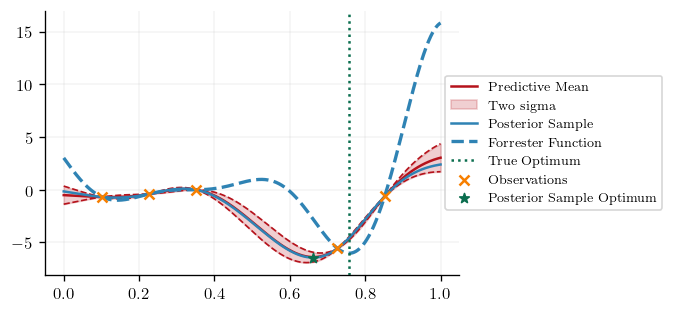

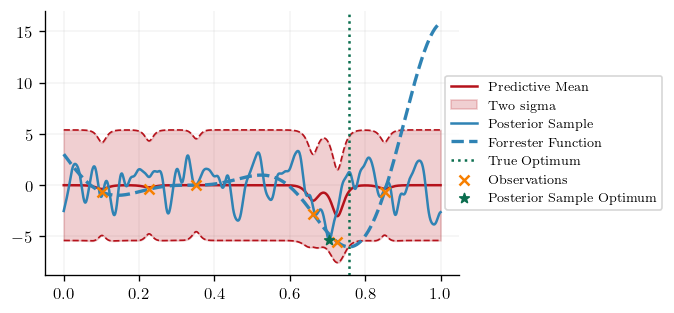

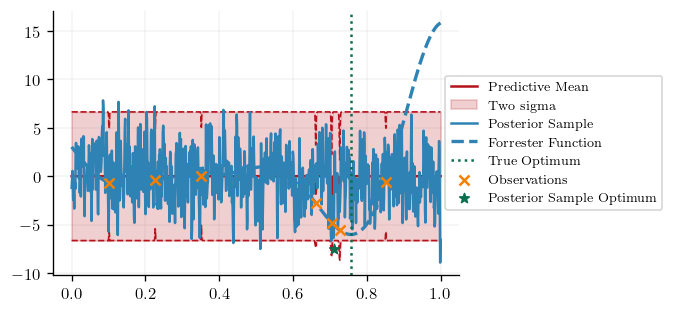

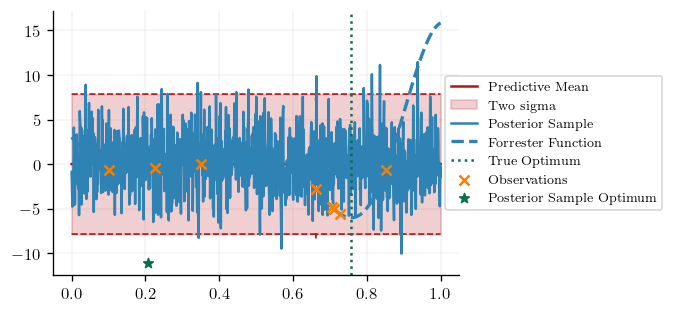

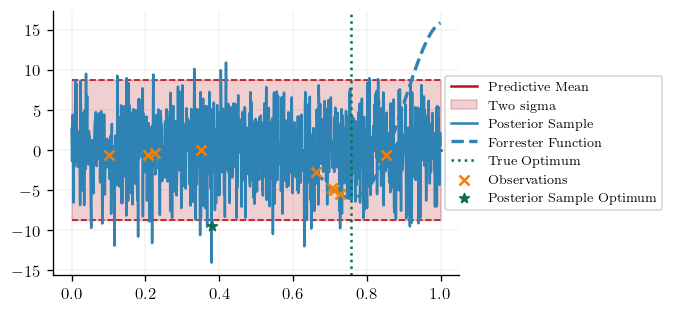

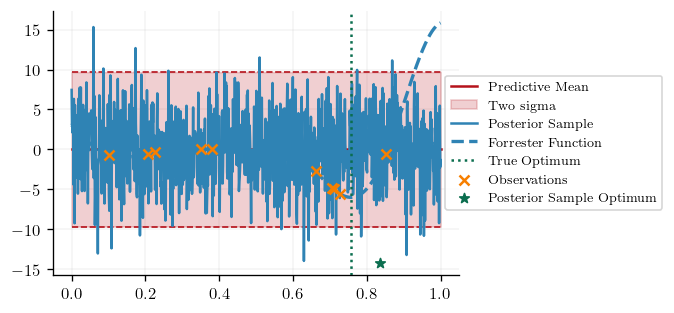

In [22]:
dm = UtilityDrivenDecisionMaker(
    search_space=search_space,
    posterior_handlers=posterior_handlers,
    datasets=initial_datasets,
    utility_function_builder=utility_function_builder,
    utility_maximizer=acquisition_maximizer,
    batch_size=1,
    key=key,
    post_ask=[plot_bo_iteration],
    post_tell=[],
)

results = dm.run(
    6,
    black_box_function_evaluator=function_evaluator,
)

We can see that our `DecisionMaker` is successfully able to find the minimimizer of the
black box function!



## Conclusions

In this notebook we have provided an introduction to the new `decision_making` module of
GPJax. We have demonstrated how one may use the abstractions provided by this module to
implement a Bayesian optimisation loop, and have also highlighted some of the
flexibility provided by the module. We hope that this module will provide a useful
framework for solving a wide range of sequential decision making problems, and that it
will be easy for users to extend the functionality provided by the module to suit their
needs!

We should note that the `decision_making` module is still in its early stages, and so
whilst we hope to avoid making breaking changes to it, they may occur as the module
evolves and more advanced functionality is implemented. If people have any feedback or
features they would like to implement/see implemented, feel free to open an issue on the
[GPJax GitHub page](https://github.com/JaxGaussianProcesses/GPJax/issues).


## System Configuration

In [ ]:
%reload_ext watermark
%watermark -n -u -v -iv -w -a 'Thomas Christie'